<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/Python-Notebook-Banners/Code_challenge.png"  style="display: block; margin-left: auto; margin-right: auto;";/>
</div>

## Integrated Project: Understanding the yield
© ExploreAI Academy

In this coding challenge, we will apply all of the skills we learned in regression.

⚠️ **Note that this code challenge is graded and will contribute to your overall marks for this module. Submit this notebook for grading. Note that the names of the functions are different in this notebook. Transfer the code in your notebook to this submission notebook**

### Instructions

- **Do not add or remove cells in this notebook. Do not edit or remove the `### START FUNCTION` or `### END FUNCTION` comments. Do not add any code outside of the functions you are required to edit. Doing any of this will lead to a mark of 0%!**

- Answer the questions according to the specifications provided.

- Use the given cell in each question to see if your function matches the expected outputs.

- Do not hard-code answers to the questions.

- The use of StackOverflow, Google, and other online tools is permitted. However, copying a fellow student's code is not permissible and is considered a breach of the Honour code. Doing this will result in a mark of 0%.

# Introduction to simple linear regression

Simple linear regression is a fundamental statistical method used to quantify the relationship between two variables. It allows us to predict an outcome (dependent variable) based on the value of one predictor (independent variable). In this challenge, we will apply simple linear regression to understand how different environmental factors affect the standardised yield of crops.

Our insights will not only help local farmers maximise their harvests but also contribute to the sustainable agriculture practices in Maji Ndogo.



# Initial data exploration

Before we sow the seeds of our regression model, we need to get to know our soil – the dataset. This dataset was developed through extensive agricultural surveys conducted at farms across Maji Ndogo. It contains various factors that might influence a farm's crop yield, from the elevation of the fields to the average temperature they bask in.

Spend some time looking at the data dictionary and start thinking about what could be influencing our crop yield.

# Data dictionary

**1. Geographic features**

- **Field_ID:** A unique identifier for each field (BigInt).

- **Elevation:** The elevation of the field above sea level in metres (Float).

- **Latitude:** Geographical latitude of the field in degrees (Float). (DUMMY VARIABLE- the simulation might have created a relationship)

- **Longitude:** Geographical longitude of the field in degrees (Float). (DUMMY VARIABLE- the simulation might have created a relationship)

- **Location:** Province the field is in (Text).

- **Slope:** The slope of the land in the field (Float).

**2. Weather features**

- **Rainfall:** Amount of rainfall in the area in mm (Float).

- **Min_temperature_C:** Average minimum temperature recorded in Celsius (Float).(DUMMY VARIABLE)

- **Max_temperature_C:** Average maximum temperature recorded in Celsius (Float).(DUMMY VARIABLE)

- **Ave_temps:** Average temperature in Celcius (Float).

**3. Soil and crop features**

- **Soil_fertility:** A measure of soil fertility where 0 is infertile soil, and 1 is very fertile soil (Float).

- **Soil_type:** Type of soil present in the field (Text).

- **pH:** pH level of the soil, which is a measure of how acidic/basic the soil is (Float).

**4. Farm management features**

- **Field_ID:** Corresponding field identifier (BigInt).

- **Pollution_level:** Level of pollution in the area where 0 is unpolluted and 1 is very polluted (Float).

- **Plot_size:** Size of the plot in the field (Ha) (Float). (DUMMY VARIABLE)

- **Chosen_crop:** Type of crop chosen for cultivation (Text).

- **Annual_yield:** Annual yield from the field (Float). This is the total output of the field. The field size and type of crop will affect the Annual Yield (DUMMY VARIABLE - Removed)

<br>

**5. Target variable**
- **Standard_yield:** Standardised yield expected from the field, normalised per crop (Float). This is independent of field size, or crop type. Multiplying this number by the field size, and average crop yield will give the Annual_Yield.

---

Let's import our database again, like we did last time. We won't use the weather data so it is commented out.

**Important:** Ensure that `data_ingestion.py` file and the `field_data_processor.py` files are stored in the same folder as your notebook, otherwise the data import will fail. The links to the files are below:

[Download files here](https://github.com/Explore-AI/Public-Data/raw/master/Maji_Ndogo/modules.zip)


In [1]:
# Read the database, and clean the data using the processing modules we built.

import re
import numpy as np
import pandas as pd
from field_data_processor import FieldDataProcessor
# from weather_data_processor import WeatherDataProcessor
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

config_params = {
    "sql_query": """
            SELECT *
            FROM geographic_features
            LEFT JOIN weather_features USING (Field_ID)
            LEFT JOIN soil_and_crop_features USING (Field_ID)
            LEFT JOIN farm_management_features USING (Field_ID)
            """,
    "db_path": 'sqlite:///Maji_Ndogo_farm_survey_small.db',
    "columns_to_rename": {'Annual_yield': 'Crop_type', 'Crop_type': 'Annual_yield'},
    "values_to_rename": {'cassaval': 'cassava', 'wheatn': 'wheat', 'teaa': 'tea'},
    "weather_csv_path": "https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Maji_Ndogo/Weather_station_data.csv",
    "weather_mapping_csv": "https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Maji_Ndogo/Weather_data_field_mapping.csv",
    "regex_patterns" : {
            'Rainfall': r'(\d+(\.\d+)?)\s?mm',
            'Temperature': r'(\d+(\.\d+)?)\s?C',
            'Pollution_level': r'=\s*(-?\d+(\.\d+)?)|Pollution at \s*(-?\d+(\.\d+)?)'
            },
}
# Ignoring the field data for now.
field_processor = FieldDataProcessor(config_params)
field_processor.process()
field_df = field_processor.df

# We're not going to use the weather data this time, so we'll ignore it.
# weather_processor = WeatherDataProcessor(config_params)
# weather_processor.process()
# weather_df = weather_processor.weather_df

dataset = field_df.drop("Weather_station", axis=1)

2024-03-10 12:40:19,806 - data_ingestion - INFO - Database engine created successfully.
2024-03-10 12:40:20,260 - data_ingestion - INFO - Query executed successfully.
2024-03-10 12:40:20,262 - field_data_processor.FieldDataProcessor - INFO - Sucessfully loaded data.
2024-03-10 12:40:20,273 - field_data_processor.FieldDataProcessor - INFO - Swapped columns: Annual_yield with Crop_type
2024-03-10 12:40:22,311 - data_ingestion - INFO - CSV file read successfully from the web.


In [2]:
dataset

,Field_ID,Elevation,Latitude,Longitude,Location,Slope,Rainfall,Min_temperature_C,Max_temperature_C,Ave_temps,Soil_fertility,Soil_type,pH,Pollution_level,Plot_size,Annual_yield,Crop_type,Standard_yield
0,40734,786.05580,-7.389911,-7.556202,Rural_Akatsi,14.795113,1125.2,-3.1,33.1,15.00,0.62,Sandy,6.169393,8.526684e-02,1.3,0.751354,cassava,0.577964
1,30629,674.33410,-7.736849,-1.051539,Rural_Sokoto,11.374611,1450.7,-3.9,30.6,13.35,0.64,Volcanic,5.676648,3.996838e-01,2.2,1.069865,cassava,0.486302
2,39924,826.53390,-9.926616,0.115156,Rural_Sokoto,11.339692,2208.9,-1.8,28.4,13.30,0.69,Volcanic,5.331993,3.580286e-01,3.4,2.208801,tea,0.649647
3,5754,574.94617,-2.420131,-6.592215,Rural_Kilimani,7.109855,328.8,-5.8,32.2,13.20,0.54,Loamy,5.328150,2.866871e-01,2.4,1.277635,cassava,0.532348
4,14146,886.35300,-3.055434,-7.952609,Rural_Kilimani,55.007656,785.2,-2.5,31.0,14.25,0.72,Sandy,5.721234,4.319027e-02,1.5,0.832614,wheat,0.555076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5649,11472,681.36145,-7.358371,-6.254369,Rural_Akatsi,16.213196,885.7,-4.3,33.4,14.55,0.61,Sandy,5.741063,3.286828e-01,1.1,0.609930,potato,0.554482
5650,19660,667.02120,-3.154559,-4.475046,Rural_Kilimani,2.397553,501.1,-4.8,32.1,13.65,0.54,Sandy,5.445833,1.602583e-01,8.7,3.812289,maize,0.438194
5651,41296,670.77900,-14.472861,-6.110221,Rural_Hawassa,7.636470,1586.6,-3.8,33.4,14.80,0.64,Volcanic,5.385873,8.221326e-09,2.1,1.681629,tea,0.800776
5652,33090,429.48840,-14.653089,-6.984116,Rural_Hawassa,13.944720,1272.2,-6.2,34.6,14.20,0.63,Silt,5.562508,6.917245e-10,1.3,0.659874,cassava,0.507595


Before diving into our analysis, it's crucial to ensure the integrity of our dataset and that the data is still as we expect it to be.

In [3]:
# Validate the data
# !pip install pytest

dataset.to_csv('sampled_field_df.csv', index=False)

!pytest validate_data.py -v

import os# Define the file paths
field_csv_path = 'sampled_field_df.csv'

# Delete sampled_field_df.csv if it exists
if os.path.exists(field_csv_path):
    os.remove(field_csv_path)
    print(f"Deleted {field_csv_path}")
else:
    print(f"{field_csv_path} does not exist.")

Deleted sampled_field_df.csv


'pytest' is not recognized as an internal or external command,
operable program or batch file.


# Analysis

## Challenge 1: Visualising the relationship

With our data ready and loaded, it's time to start exploring.

Our goal is to determine whether any of the features in our dataset are influencing the `Standard_yield` of a farm. If we can figure out what these relationships are, then we can use them to start predicting what future yields will be, based on these features.

For this analysis, we want to find whether any features have a linear relationship with `Standard_yield` so that we can fit a linear regression model to the data. This is important because if we try and fit a linear regression model to non-linear data, our predictions won't be good.

Any of the features could have an impact on the `Standard_yield`. Let's begin with `Ave_temps`, the average temperature of the region, and its relationship to `Standard_yield`.

Let's start with the basics: a scatter plot.


**⚙️ Your task:**

 1. Generate a scatter plot to visualise the relationship between `Ave_temps` and `Standard_yield`.
 2. Reflect on the scatter plot. Does it suggest a linear relationship, or is the story more complex?

**Note:**
- Use `matplotlib` to create the scatter plot.

In [4]:
import matplotlib.pyplot as plt

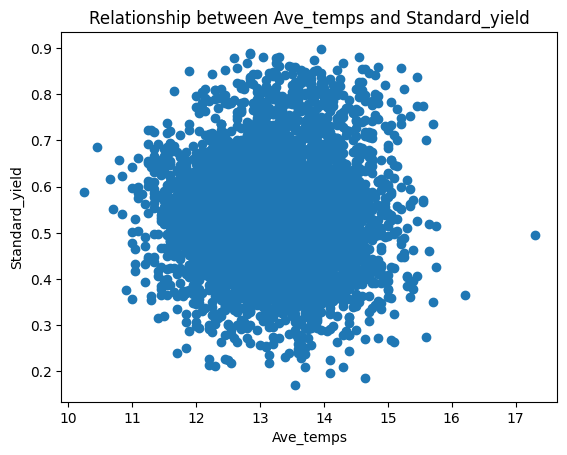

Pearson correlation coefficient: 0.006785950289020211


In [70]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def temp_yield_correlation(df, temp_col='Ave_temps', yield_col='Standard_yield'):
    """
    Visualizes the relationship between average temperature and standard yield in a scatter plot,
    calculates the Pearson correlation coefficient, and returns this coefficient.

    Parameters:
    - df: DataFrame containing the data.
    - temp_col: Name of the column representing average temperature ('Ave_temps').
    - yield_col: Name of the column representing standard yield ('Standard_yield').

    Returns:
    - The Pearson correlation coefficient as a float.
    """
    # Generate scatter plot
    plt.scatter(df[temp_col], df[yield_col])
    plt.xlabel(temp_col)
    plt.ylabel(yield_col)
    plt.title(f'Relationship between {temp_col} and {yield_col}')
    plt.show()
    
    # Calculate Pearson correlation coefficient
    correlation, _ = pearsonr(df[temp_col], df[yield_col])
    
    return correlation

# Usage example 
correlation = temp_yield_correlation(dataset)
print("Pearson correlation coefficient:", correlation)

Now, let's write a function to calculate the Pearson correlation coefficient.

**⚙️ Your task:**

Create a function named `get_correlation` that:
1. Takes a DataFrame and the names of the columns we want to determine the correlation for as parameters (`Ave_temps` and `Standard_yield`).
2. Calculates the Pearson correlation coefficient between these two columns to quantify their linear relationship.
4. Returns the Pearson correlation coefficient.

**Note:**
- Use `scipy` to calculate the Pearson correlation coefficient.
- Ensure your function returns the Pearson correlation coefficient as a float.

In [6]:
from scipy.stats import pearsonr

In [71]:
### START FUNCTION
def get_correlation(df, col1, col2):
    # Add code to calculate and return the correlation coefficient
    """
    Calculate the correlation between temperature and crop yield.

    Parameters:
    - df (pd.DataFrame): The input DataFrame containing the data.
    - col1 (str): The column name representing average temperatures.
    - col2 (str): The column name representing standard crop yields.

    Returns:
    - correlation (float): The correlation coefficient between temperature and crop yield.
    """
    
    # Insert your code here
    # Check if the specified columns exist in the DataFrame
    if col1 not in df.columns or col2 not in df.columns:
        raise ValueError("Specified columns not found in the DataFrame.")

    # Calculate Pearson correlation coefficient
    correlation_coefficient, _ = pearsonr(df[col1], df[col2])

    return correlation_coefficient

### END FUNCTION

Input:

In [72]:
correlation = get_correlation(dataset,'Ave_temps','Standard_yield')
print("Pearson correlation coefficient:", correlation)

Pearson correlation coefficient: 0.006785950289020211


Expected output
```
Correlation: 0.006785950289020164
```

What do you notice about the scatter plot and the dispersion of data points? It's essential to visualise our data first; if the data doesn't follow a linear pattern, then a linear regression model may fail to accurately capture the underlying relationship. The correlation also seems extremly low, what does this tell us?

Let's write down some of our observations:

  - ✍️ Your notes here

## Challenge 2: A breath of fresh data: Pollution as a predictor


It's time to shift our gaze from the warmth of the sun to the haze of pollution. Could the levels of pollution, a concern for farmers and environmentalists alike, be an indicator of our yields?

Let's begin by fitting a simple linear regression model, to try and capture the linear relationship between these columns.

**⚙️ Your task:**

Create a function named `fit_linear_regression_model` that:
1. Takes in a DataFrame and the names of the `Pollution_level` and `Standard_yield` columns.
2. Fits a linear regression model to the data.
3. Returns the model, the model predictions and the actual y-values.

**Note:**
- Use `LinearRegression` from `sklearn` to fit the model.

In [9]:
from sklearn.linear_model import LinearRegression

In [38]:
### START FUNCTION
import seaborn as sns
def fit_linear_regression_model(df, pollution_col, yield_col):
    # Fit linear regression model
    X = df[[pollution_col]]
    y = df[yield_col]
    model = LinearRegression().fit(X, y)

    # Return the necessary values
    return model, model.predict(X), y

### END FUNCTION

Input:

In [39]:
model, predictions, y_values = fit_linear_regression_model(dataset, 'Pollution_level', 'Standard_yield')
print(f"Model: {model}")
print(f"Predictions: {predictions}")
print(f"Actual Y-Values: {y_values}")

Model: LinearRegression()
Predictions: [0.5540956  0.50920888 0.51515565 ... 0.56626844 0.56626844 0.52896886]
Actual Y-Values: 0       0.577964
1       0.486302
2       0.649647
3       0.532348
4       0.555076
          ...   
5649    0.554482
5650    0.438194
5651    0.800776
5652    0.507595
5653    0.453064
Name: Standard_yield, Length: 5654, dtype: float64


Expected output:
```
- Model: an instance of the LinearRegression class.
- Predictions: a NumPy array of predicted values.
- y: a Pandas Series with the actual target values used for training.
```

Linear regression models only work well if our data is in fact linear. So, lets create a scatter plot to visualise the relationship between pollution and crop yields. In addition to this, let's use the predictions from the model we fit to add the line of best fit to our scatter plot.

**⚙️ Your task:**

1. Generate a scatter plot to visualise the effect that pollution has on standard yield.
2. Draw the line of best fit

**Hint:**

You can use this line of code to draw the regression line on the plot:
`plt.plot(X, predictions, color='red', label='Regression line')`

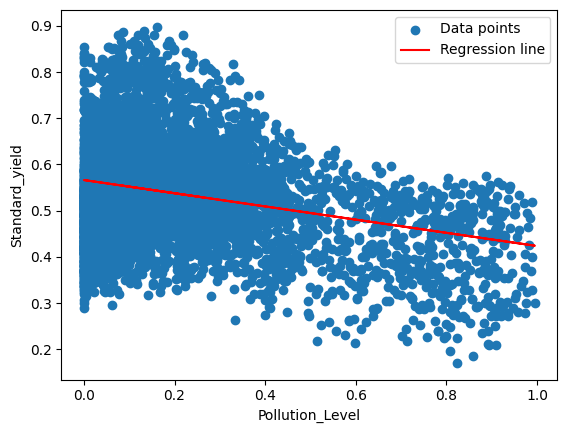

In [36]:
X = dataset[['Pollution_level']]
y = dataset['Standard_yield']

# Add code to draw the scatter plot and the regression line
def pollution_yield_relationship(df, pollution_col, yield_col):
    X = dataset[['Pollution_level']]
    y = dataset['Standard_yield']
    
    model = LinearRegression().fit(X, y)
    predictions = model.predict(X)
    
    plt.scatter(X, y, label='Data points')
    plt.plot(X, predictions, color='red', label='Regression line')
    plt.xlabel(pollution_col)
    plt.ylabel(yield_col)
    plt.legend()
    plt.show()
    
    return (model.coef_[0], model.intercept_)
### END FUNCTION

slope_intercept = pollution_yield_relationship(dataset, 'Pollution_Level', 'Standard_yield')

Now, use the get_correlation() function that we defined earlier to test the correlation between `Pollution_level` and `Standard_yield`.

In [37]:
Pollution_correlation = get_correlation(dataset,'Pollution_level','Standard_yield')
print("Pearson correlation coefficient:", Pollution_correlation)

Correlation: -0.2857609646210545
Pearson correlation coefficient: None


Expected output
```
Correlation: -0.2857609646210543
```

Reflect on the difference between this plot and correlation and the previous one with the average temperature. Is the relationship between pollution and yield more linear?

  - ✍️ Your notes here


We can also gain a better understanding of our model by examining the slope and intercept.

**⚙️ Your task:**

Create a function named `get_slope_intercept` that:
1. Inputs the `model` we fitted and calculates the slope and intercept of the line of best fit.
2. Return the slope and intercept as a tuple.


In [66]:
### START FUNCTION
def get_slope_intercept(model):

    # Extract slope and intercept from the fitted model
    slope = model.coef_[0]
    intercept = model.intercept_

    return slope, intercept

### END FUNCTION

Input:

In [67]:
slope, intercept = get_slope_intercept(model)
print("Slope:", slope)
print("Intercept:", intercept)

Slope: -0.1427617720986607
Intercept: 0.566268441539338


Expected output:
```
Slope: -0.1427617720986604
Intercept: 0.5662684415393379
```


What does the slope tell us about the strength of the relationship between pollution and yield? Also, what can we learn from the y-intercept?

  - ✍️ Your notes here


## Challenge 3: The haze clears: Evaluating pollution's predictive power

When we look at the scatterplots of `Standard_yield` with `Ave_temps` and `Pollution_level`, it appears that pollution level might have a more linear relationship.  This means that we could potentially use a simple linear regression model to make predictions about the yield of a farm based on its pollution level. However, before we do this we need to further assess the strength of the linear relationship between `Pollution_level` and `Standard_yield`.

Let's assess our model's performance using R-squared, Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE).

**⚙️ Your task:**

Create a function named `calculate_evaluation_metrics` that:
1. Takes the predictions and y-values from our fitted model as input.
2. Calculates and returns the R-squared, Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE) of the model's performance.

**Note:**
1. Calculate the model's performance metrics using the entire dataset.
2. Return the evaluation metrics as a tuple in the order: R-squared, MAE, MSE, RMSE.

In [45]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

In [46]:
### START FUNCTION
def calculate_evaluation_metrics(predictions, y_values):
    """
    Calculate R-squared, Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE).

    Parameters:
    - predictions: Predicted values from the model.
    - y_values: Actual values (ground truth).

    Returns:
    Tuple containing R-squared, MAE, MSE, and RMSE.
    """
    r2 = r2_score(y_values, predictions)
    mae = mean_absolute_error(y_values, predictions)
    mse = mean_squared_error(y_values, predictions)
    rmse = np.sqrt(mse)

    return r2, mae, mse, rmse

### END FUNCTION

Input:

In [47]:
evaluation_metrics = calculate_evaluation_metrics(predictions, y_values)
print(f"Evaluation Metrics:\nR-squared: {evaluation_metrics[0]}\nMAE: {evaluation_metrics[1]}\nMSE: {evaluation_metrics[2]}\nRMSE: {evaluation_metrics[3]}")

Evaluation Metrics:
R-squared: 0.08165932890115568
MAE: 0.08554642090904993
MSE: 0.011477732254034844
RMSE: 0.10713417873878926


Expected output:

A tuple containing numerical values for R-squared, MAE, MSE, and RMSE (give or take 0.0001):

```python
R-squared: 0.08165932890115546
MAE: 0.08554642090904992
MSE: 0.011477732254034848
RMSE: 0.10713417873878928

```

Think about what these metrics tell us about our model's accuracy and reliability. Write down your observations:

  - ✍️ Your notes here


## Challenge 4: The dividing line: Train-test split in action

As we delve deeper into the relationship between `Pollution_level` and `Standard_yield`, we must ensure our model is not merely memorising the data but truly understanding it. This brings us to the pivotal technique of Train-Test Split.

**The importance of train-test split**

Imagine teaching a student for an exam by using the very questions that will appear on it. They might score perfectly, but does it mean they've truly learned? Similarly, a model might perform exceptionally on the data it was trained on, but the real test of knowledge comes from unseen data. This is where the train-test split comes in, allowing us to assess our model's generalisation capabilities by training on one subset of data and testing on another.

**Your task**

Create a function named `data_train_test_split` that:
1. Takes in the DataFrame and the two columns we want to model the relationship between (`Pollution_level` and `Standard_yield`).
2. Separates it into features (`X`) based on `Pollution_level` and the target (`y`) based on `Standard_yield`.
3. Splits the data into training and testing sets using an 80-20 split and sets `random_state = 42` for reproducibility.
4.  Returns a tuple containing: `X_train` and `X_test`, which are DataFrames containing features for training and testing, respectively, along with `y_train` and `y_test`, which are Series representing subsets of the original DataFrame's target variable for training and testing.

**Note:**
- Use `train_test_split` from `sklearn.model_selection` to split the data.
- Train a linear regression model on the training set using `LinearRegression` from `sklearn.linear_model`.
- If the random state is not set to `42` the code will not be marked correctly.

In [48]:
from sklearn.model_selection import train_test_split

In [51]:
### START FUNCTION
def data_train_test_split(df, pollution_col, yield_col):
   """
    Split the data into training and testing sets based on pollution and yield columns.

    Parameters:
    - df: DataFrame containing the dataset.
    - pollution_col: Column name for the pollution levels.
    - yield_col: Column name for the yield values.

    Returns:
    Tuple containing X_train, X_test, y_train, y_test.
    """
   X = df[[pollution_col]]
   y = df[yield_col]

    # Split the data into training and testing sets using an 80-20 split
   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

   return X_train, X_test, y_train, y_test

### END FUNCTION

Input:

In [52]:
X_train, X_test, y_train, y_test = data_train_test_split(dataset, 'Pollution_level', 'Standard_yield')
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (4523, 1), X_test shape: (1131, 1)
y_train shape: (4523,), y_test shape: (1131,)


Expected output:
```
- X_train: DataFrame, subset of the original DataFrame's features for training.
- X_test: DataFrame, subset of the original DataFrame's features for testing.
- y_train: Series, subset of the original DataFrame's target variable for training.
- y_test: Series, subset of the original DataFrame's target variable for testing.
```

Now lets fit a linear regression model to the data.

**Your task**

Create a function named `train_split_linear_regression_model()` that:
1. Takes `X_train`, `X_test`, `y_train`, `y_test` as input (the results from the `data_train_test_split()` function).
2. Trains a simple linear regression model on the training set.
3. Uses the testing set to make predictions.
4. Returns a tuple containing: the model, the predictions and y_test (the actual y values in the testing set values) .

In [53]:
from sklearn.linear_model import LinearRegression

In [56]:
### START FUNCTION
def train_split_linear_regression_model(X_train, X_test, y_train, y_test):
    """
    Fit a linear regression model to the training data and make predictions on the testing data.

    Parameters:
    - X_train: Features of the training set.
    - X_test: Features of the testing set.
    - y_train: Target values of the training set.
    - y_test: Target values of the testing set.

    Returns:
    Tuple containing the fitted model, predictions, and actual values (y_test).
    """
    # Check if the input data is not empty
    if X_train.empty or X_test.empty or y_train.empty or y_test.empty:
        raise ValueError("Input data is empty.")

    # Train the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions on the testing set
    predictions = model.predict(X_test)

    return model, predictions, y_test

### END FUNCTION

Input:

In [57]:
train_test_model, predictions_test, y_test = train_split_linear_regression_model(X_train, X_test, y_train, y_test)
print(f"Train-Test Model: {train_test_model}")
print(f"Test Predictions: {predictions_test}")
print(f"Test Actual Y-Values: {y_test}")

Train-Test Model: LinearRegression()
Test Predictions: [0.56412206 0.56167249 0.55638552 ... 0.53129108 0.53868457 0.56431394]
Test Actual Y-Values: 4816    0.446290
5096    0.650771
4706    0.531284
1499    0.516429
3544    0.555724
          ...   
3982    0.540212
4952    0.670387
1071    0.353658
718     0.535224
4103    0.470315
Name: Standard_yield, Length: 1131, dtype: float64


Expected output:
```
- Model: an instance of the LinearRegression class.
- Predictions: a NumPy array of predicted values.
- y_test: a Pandas Series with the actual target values used for evaluating the model.
```

Now, let's evaluate our use our train-test model by determining R-squared, MAE, MSE, and RMSE.

**⚙️ Your task:**

1. Use the `calculate_evaluation_metrics` function (defined in Challenge 3) to calculate the R-squared, MAE, MSE, and RMSE.
2. The function should return a tuple containing the evaluation metrics (R-squared, MAE, MSE, and RMSE).

**Note:**

- Ensure to use the test set to calculate the evaluation metrics.

In [59]:
def calculate_evaluation_metrics(predictions, y_values):
    """
    Calculate R-squared, MAE, MSE, and RMSE for model evaluation.

    Parameters:
    - predictions: Predicted values from the model.
    - y_values: Actual values.

    Returns:
    Tuple containing R-squared, MAE, MSE, and RMSE.
    """
    # Calculate R-squared
    r_squared = r2_score(y_values, predictions)

    # Calculate MAE (Mean Absolute Error)
    mae = mean_absolute_error(y_values, predictions)

    # Calculate MSE (Mean Squared Error)
    mse = mean_squared_error(y_values, predictions)

    # Calculate RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mse)

    return r_squared, mae, mse, rmse

evaluation_metrics = calculate_evaluation_metrics(predictions_test, y_test)
print(f"Evaluation Metrics on Test Set:\nR-squared: {evaluation_metrics[0]}\nMAE: {evaluation_metrics[1]}\nMSE: {evaluation_metrics[2]}\nRMSE: {evaluation_metrics[3]}")

Evaluation Metrics on Test Set:
R-squared: 0.08065722992150848
MAE: 0.087949421197475
MSE: 0.012250634233355656
RMSE: 0.11068258324305436


Expected output:

A tuple containing numerical values for R-squared, MAE, MSE, and RMSE (give or take 0.0001):

```python
R-squared: 0.08065722992150859
MAE:  0.08794942119747501
MSE: 0.012250634233355654
RMSE: 0.11068258324305434

```

Reflect on the difference between these metics and the metrics we obtained from the previous model (that was not split into training and testings sets). Why do you think the fit is worse now? And, why should we choose the worse option? (Reflect on the course material if these answers to these questions are not clear.)

  - ✍️ Your notes here


## Challenge 5: Diagnosing model fit through residual analysis

From our analysis, it seems as though neither `Ave_temps` or `Pollution_level` have a strong linear fit with `Standard_yield`. However, even if we had obtained good results from our evaluation metrics, there are still other crucial assumptions we need to verify to ensure our model is well-fitted. Residual analysis plays a pivotal role in diagnosing the fit of linear regression models, helping us understand whether the assumptions of linearity, independence, and homoscedasticity (constant variance) of residuals are met.

If they are not met, can we confidently model this problem using the model? And why?

  - ✍️ Your notes here

First, let's create a histogram.

**⚙️ Your task:**

1. Calucate the residuals of our train test model (difference between `y_test` and `predictions_test`)
2. Plot these residuals as a histogram to assess their distribution and identify any patterns.

In [60]:
import matplotlib.pyplot as plt

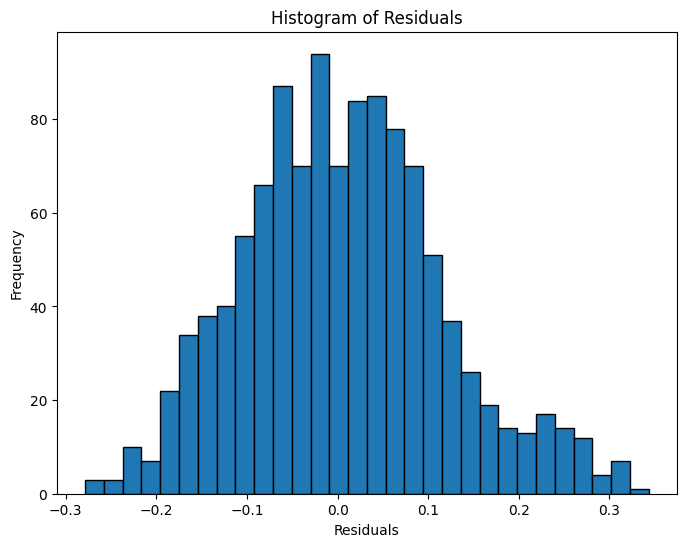

In [61]:
residuals = y_test - predictions_test # calculating the residuals

# Create a histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

What does the histogram tell us about our data:

1. Examine the shape of the histogram. What does the distribution of residuals tell us about the normality of the data? Consider whether the residuals appear to be symmetrically distributed around zero.

    - ✍️ Your notes here

2. Compare the tails of the histogram to a normal distribution. Are there signs of heavy tails or skewness that could affect the reliability of the regression model's predictions?

    - ✍️ Your notes here

3. Assess the centering of the histogram around the zero line. How does this central tendency reflect on the bias of the model's predictions?

    - ✍️ Your notes here

Now, let's create a scatter plot of these residuals against the predicted values.

**⚙️ Your task:**

1. Create a scatter plot of the residuals against the predicted values - `predictions_test` should be on the x-axis and the `residuals` on the y-axis.

**Note:**

- A horizontal line can be added at y=0 to make it easier to see if the residuals are evenly distributed around zero by adding this line of code:
`plt.axhline(y=0, color='r', linestyle='--')`


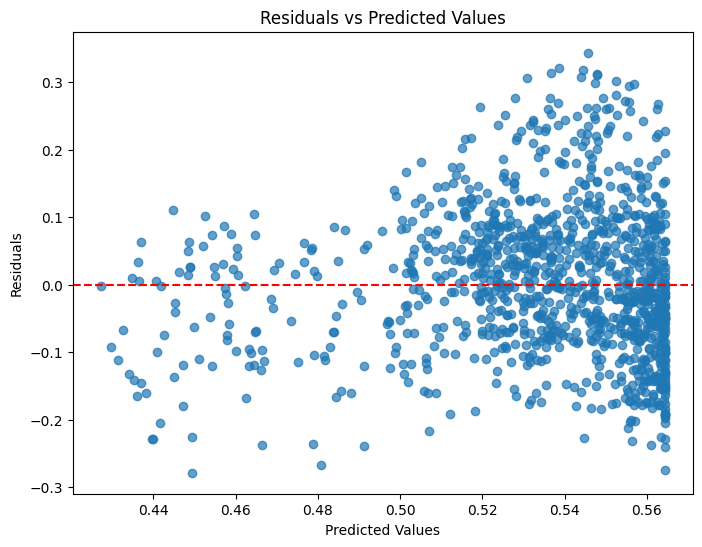

In [62]:
# Create a scatter plot of residuals against predicted values
plt.figure(figsize=(8, 6))
plt.scatter(predictions_test, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

Relfect on what the scatter plot tells us about our data and the fit of the model:

1. Analyse the scatter plot for any apparent patterns or structures in the data. What does this suggest about the appropriateness of the linear regression model for the dataset?

    - ✍️ Your notes here

2. Inspect the plot for signs of heteroscedasticity. How does the spread of residuals change as the predicted values increase? What might this imply about the constant variance assumption in linear regression?

    - ✍️ Your notes here

3. Identify whether the residuals are evenly scattered above and below the zero line across the range of predicted values. What can this tell us about the model's performance in terms of bias and prediction accuracy?

    - ✍️ Your notes here

4. Look for outliers or clusters of points that deviate significantly from the majority. How might these points influence the overall fit of the model?

    - ✍️ Your notes here


Our final task is to examine the mean and standard deviation of the residuals, which provide further insights into the model's performance.

**⚙️ Your task:**

Create a function named `calculate_residuals_statistics` that:
1. Uses the `predictions_test` and `y_test` (obtained from Challenge 4) to calculate the residuals.
2. Calculates the mean and standard deviation of the residuals.

**Note:**

- Use `numpy` for the mean and standard deviation.

In [63]:
import numpy as np

In [64]:
### START FUNCTION
def calculate_residuals_statistics(predictions, y_test):

    # Calculate residuals
    residuals = y_test - predictions

    # Calculate mean and standard deviation of residuals
    mean_residual = np.mean(residuals)
    std_residual = np.std(residuals)

    return mean_residual, std_residual

### END FUNCTION

Input:

In [65]:
mean_residual, std_residual = calculate_residuals_statistics(predictions_test, y_test)
print(f"Mean: {mean_residual}\nStandard deviation: {std_residual}")

Mean: 0.005858023192321698
Standard deviation: 0.11052745268770955


Expected output:
```
Mean: 0.0058580231923217015
Standard deviation: 0.11052745268770957
```

What does the mean of the residuals tell us about the bias in our predictions? How does a mean close to zero reflect on our model's accuracy?

- ✍️ Your notes here

What does the standard deviation of the residuals indicate about the variability of our predictions? Why is it important for this value to be relatively low?

 - ✍️ Your notes here

What are the potential consequences of a high standard deviation of residuals on the reliability of the model's predictions? How might this affect our confidence in the model's estimates?

- ✍️ Your notes here

## Conclusion

Linear regression, for all its strengths, assumes a straightforward relationship between the predictor and the outcome. Yet, the natural world seldom adheres to such simplicity. Factors influencing crop yields in Maji Ndogo—be it temperature, rainfall, or pollution—interact in complex, often nonlinear ways. Our initial model with `Ave_temps` hinted at this complexity, suggesting that the effect of the average temperature on yields might follow a more intricate pattern than a straight line can depict (or no pattern at all).

Our yield also depends on more than just the pollution or the temperature, it depends on many of the factors. From our EDA we could see that. We also saw that not all crops are affected equally by pollution or temperature, so we could simplify our model if we remove the influence of the different crops. Once your submission is done, as a challenge to yourself, try to split the data again by crop type (with a loop) and use the functions you created to loop over all of the crop types and print out your metrics.

Compare them, and discuss your results with your colleagues. Is there a crop type that is affected by pollution more than other crop types?

As we dive deeper into regression, it's crucial to remember that with each model comes a new perspective. Just as a farmer selects the tool that best suits the task at hand, so must we choose our models with intention and insight. Exploring beyond linear regression opens up new vistas of understanding, allowing us to capture the richness of relationships within our data.

In the fields of Maji Ndogo and beyond, countless stories await. It's up to us, with curiosity as our guide and an ever-expanding array of models at our disposal, to uncover them.

#  

<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/ExploreAI_logos/EAI_Blue_Dark.png"  style="width:200px";/>
</div>